Optimization started...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     11 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0271009352 |         ideal
     3 |      300 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0083402706 |         ideal
     4 |      400 |     18 |  0.000000E+00 |  0.000000E+00 |  0.1225266988 |         ideal
     5 |      500 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0056315459 |         ideal
     6 |      600 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0274705868 |         ideal
     7 |      700 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0502211138 |         ideal
     8 |      800 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0101404469 |             f
     9 |      900 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0229270009 |         ideal
    10 |     1000 |     30 |  0.000000E+00 |  0.000000E+00 |  0.39

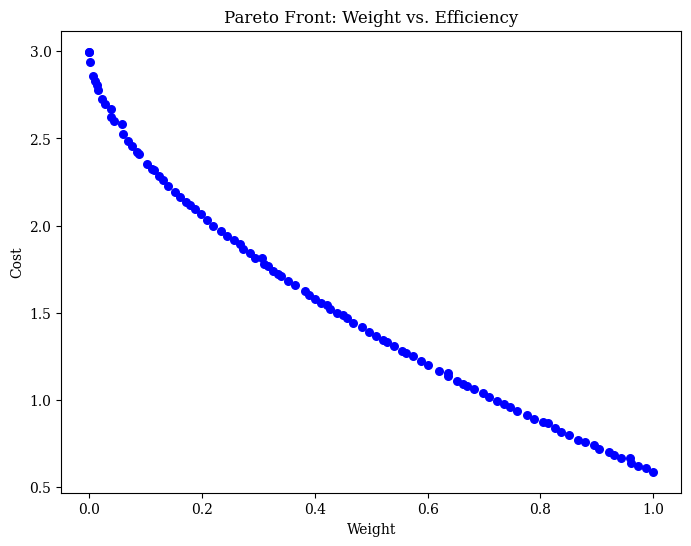

In [3]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class MechanicalOptimization(ElementwiseProblem):

    def __init__(self):
        # n_var: Number of input variables
        # n_obj: Number of goals
        # n_ieq_constr: Number of constraints
        super().__init__(n_var=10, 
                         n_obj=2, 
                         n_ieq_constr=1, 
                         xl=np.zeros(10), # Lower bounds (all 0)
                         xu=np.ones(10))  # Upper bounds (all 1)

    def _evaluate(self, x, out, *args, **kwargs):
        # Goal 1: Minimize the first variable (e.g., Material Volume)
        f1 = x[0]
        
        # Goal 2: A complex function representing efficiency (ZDT1 logic)
        g = 1 + 9 * np.sum(x[1:]) / (self.n_var - 1)
        f2 = g * (1 - np.sqrt(x[0] / g))

        # Constraint: The sum of variables must be at least 2.0
        # Formula: 2.0 - sum(x) <= 0
        con1 = 2.0 - np.sum(x)

        out["F"] = [f1, f2]
        out["G"] = [con1]

if __name__ == "__main__":

    # Initialize the NSGA-II Algorithm
    algorithm = NSGA2(
        pop_size=100,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PolynomialMutation(prob=1.0, eta=20),
        eliminate_duplicates=True
    )

    # Run the optimization process
    print("Optimization started...")
    res = minimize(
        MechanicalOptimization(),
        algorithm,
        termination=('n_gen', 200),
        save_history=True,
        verbose=True
    )
    print("Optimization complete.")

    # 3. RESULTS & VISUALIZATION
    # Print the best variables found for the first 5 solutions
    print("\nBest Design Variables (First 5 solutions):")
    print(res.X[:5])

    # Plot the Pareto Front
    plot = Scatter(title="Pareto Front: Weight vs. Efficiency", labels=["Weight", "Cost"])
    plot.add(res.F, color="blue", s=30)
    plot.show()

Number of optimal solutions found: 50


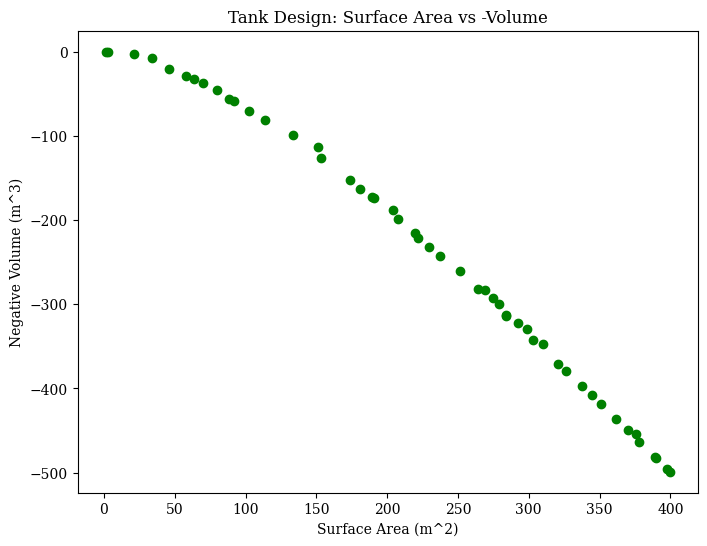

In [4]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class TankOptimization(ElementwiseProblem):

    def __init__(self):
        # 3 variables: width, length, height
        # 2 objectives: Surface Area, Volume
        # 2 constraints: Aspect ratio, Max height
        super().__init__(n_var=3, 
                         n_obj=2, 
                         n_ieq_constr=2, 
                         xl=np.array([0.5, 0.5, 0.5]), 
                         xu=np.array([10.0, 10.0, 10.0]))

    def _evaluate(self, x, out, *args, **kwargs):
        w, l, h = x[0], x[1], x[2]

        # Objective 1: Surface Area (Minimize)
        f1 = 2 * (w*l + l*h + w*h)
        
        # Objective 2: Volume (Maximize -> Minimize Negative)
        f2 = -(w * l * h)

        # Constraint 1: Height <= 2 * Width (h - 2w <= 0)
        g1 = h - (2 * w)
        
        # Constraint 2: Height <= 5 meters (h - 5 <= 0)
        g2 = h - 5.0

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]

if __name__ == "__main__":
    
    algorithm = NSGA2(pop_size=50)

    res = minimize(TankOptimization(),
                   algorithm,
                   ('n_gen', 100),
                   seed=1,
                   verbose=False)

    # Print results
    print(f"Number of optimal solutions found: {len(res.F)}")
    
    # Visualize the results
    # Since F2 is negative, the plot will show the trade-off
    plot = Scatter(title="Tank Design: Surface Area vs -Volume",
                   labels=["Surface Area (m^2)", "Negative Volume (m^3)"])
    plot.add(res.F, color="green")
    plot.show()

In [6]:
# Install the Platypus library
!pip install platypus-opt

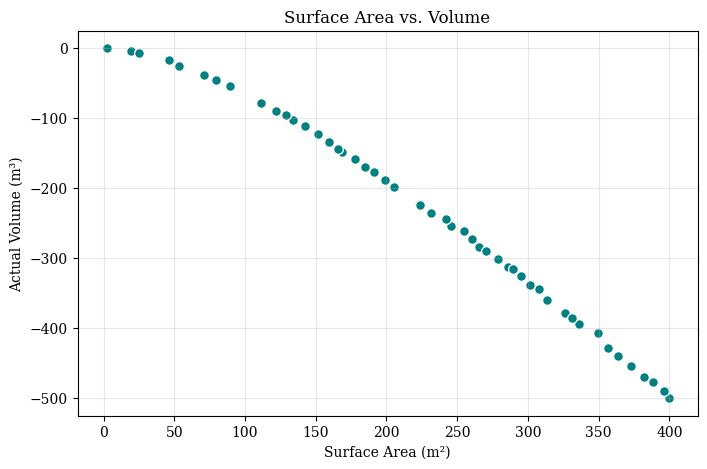

In [12]:
import matplotlib.pyplot as plt
from platypus import NSGAII, Problem, Real

# 1. THE PHYSICS
def objective_functions(vars):
    w, l, h = vars[0], vars[1], vars[2]
    f1 = 2 * (w*l + l*h + w*h)   # Surface Area
    f2 = -(w * l * h)             # Volume (Negative for minimization)
    
    g1 = h - (2 * w)              # Constraint: h <= 2w
    g2 = h - 5.0                  # Constraint: h <= 5
    return [f1, f2], [g1, g2]

# 2. THE PROBLEM SETUP
# Creating a local variable 'tank_prob' avoids clashing with pymoo's 'Problem'
tank_prob = Problem(3, 2, 2)
tank_prob.types[:] = [Real(0.5, 10.0), Real(0.5, 10.0), Real(0.5, 10.0)]
tank_prob.constraints[:] = "<=0"
tank_prob.function = objective_functions

# 3. THE OPTIMIZATION
algorithm = NSGAII(tank_prob, population_size=50)
algorithm.run(10000) 
seed=1

# 4. THE PLOTTING
surface_area = [s.objectives[0] for s in algorithm.result]
volume = [s.objectives[1] for s in algorithm.result]

plt.figure(figsize=(8, 5))
plt.scatter(surface_area, volume, color='teal', edgecolors='white', s=50)
plt.title("Surface Area vs. Volume")
plt.xlabel("Surface Area (m²)")
plt.ylabel("Actual Volume (m³)")
plt.grid(True, alpha=0.3)
plt.show()